In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/train/train_localization.zip -d /content/drive/MyDrive/train/

Archive:  /content/drive/MyDrive/train/train_localization.zip
   creating: /content/drive/MyDrive/train/train/images/
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000000_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000001_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000002_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000003_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000008_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000012_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000015_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-florence_00000016_pre_disaster.tif  
  inflating: /content/drive/MyDrive/train/train/images/hurricane-f

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import os
import tifffile
import cv2
def get_max_value(dtype):
    if np.issubdtype(dtype, np.integer):
        return np.iinfo(dtype).max
    elif np.issubdtype(dtype, np.floating):
        return 1.0
    else:
        raise ValueError(f"Unsupported data type: {dtype}")

def load_tiff_images_and_masks(image_dir, mask_dir, image_size):
    images, masks = [], []
    i = 0
    for filename in os.listdir(image_dir):
        i += 1
        if filename.endswith('.tif') and i <= 50:
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename[:-4]+"_mask.tif")

            # Load and convert image
            image = tifffile.imread(image_path)/255.0
            # image = cv2.resize(image)
            mask = tifffile.imread(mask_path)[:,:,0]/255.0
            # mask = cv2.resize(mask)

            images.append(image)
            masks.append(mask)
        else:
            break

    return np.array(images), np.array(masks)

# Parameters
image_size = (1024, 1024)
image_dir = '/content/drive/MyDrive/train/train/images'
mask_dir = '/content/drive/MyDrive/train/train/masks'

# Load and prepare data
images, masks = load_tiff_images_and_masks(image_dir, mask_dir, image_size)
print(images.shape)
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.8, random_state=42)




(50, 1024, 1024, 3)


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:

        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:

        print(e)


1 Physical GPUs, 1 Logical GPUs


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tifffile
class SegmentationDataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, image_filenames, image_dir, mask_dir, batch_size=32, image_size=(572, 572), shuffle=True):
        'Initialization'
        self.image_filenames = np.array(image_filenames)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]


        batch_image_filenames = self.image_filenames[indexes]


        X, y = self.__data_generation(batch_image_filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_image_filenames):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((len(batch_image_filenames), *self.image_size, 3))
        y = np.empty((len(batch_image_filenames), *self.image_size, 1))

        # Generate data
        for i, img_name in enumerate(batch_image_filenames):

            img_path = os.path.join(self.image_dir, img_name)
            mask_path = os.path.join(self.mask_dir, img_name)

            img = tifffile.imread(img_path)
            img = img_to_array(img) / 255.0
            X[i,] = img


            mask = tifffile.imread(mask_path[:-4]+"_mask.tif")[:,:,0]
            mask = img_to_array(mask) / 255.0
            y[i,] = mask

        return X, y

In [ ]:
from keras.models import Model
from keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D,
                                     Conv2DTranspose, concatenate)

def conv_block(input_tensor, num_filters):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters=num_filters, kernel_size=(3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

def build_unet(input_shape):
    """Function to build a U-Net using the Keras functional API"""
    inputs = Input(input_shape)

    # Contracting Path
    c1 = conv_block(inputs, 32)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 64)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 128)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 256)
    p4 = MaxPooling2D((2, 2))(c4)


    c5 = conv_block(p4, 512)

    # Expansive Path
    u6 = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 32)

    # Output Layer
    output = Conv2D(1, (1, 1), activation='sigmoid')(c9)


    model = Model(inputs=[inputs], outputs=[output])
    return model

# Create a new U-Net model
input_shape = (1024, 1024, 3)
model = build_unet(input_shape)
model.summary()


In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import numpy as np
import os

# Build and compile
model = build_unet(input_shape=(1024, 1024, 3))
model.compile(optimizer=Adam(), loss=binary_crossentropy, metrics=['accuracy'])

# paths
train_image_dir = '/content/drive/MyDrive/train/images'
train_mask_dir = '/content/drive/MyDrive/train/masks'


batch_size = 4
image_size = (1024, 1024)
validation_split = 0.15

# Get all filenames and split into training and validation
all_filenames = np.array(os.listdir(train_image_dir))
np.random.shuffle(all_filenames)
split_index = int(len(all_filenames) * (1 - validation_split))
train_filenames, val_filenames = all_filenames[:split_index], all_filenames[split_index:]


train_gen = SegmentationDataGenerator(train_filenames, train_image_dir, train_mask_dir, batch_size=batch_size, image_size=image_size)
val_gen = SegmentationDataGenerator(val_filenames, train_image_dir, train_mask_dir, batch_size=batch_size, image_size=image_size)


checkpoint = ModelCheckpoint('/content/drive/MyDrive/model_checkpoint.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)

# Training
history = model.fit(
    train_gen,
    epochs=25,
    validation_data=val_gen,
    callbacks=[checkpoint, earlystopping]
)

# Save the final model
model.save('/content/drive/MyDrive/final_model.h5')


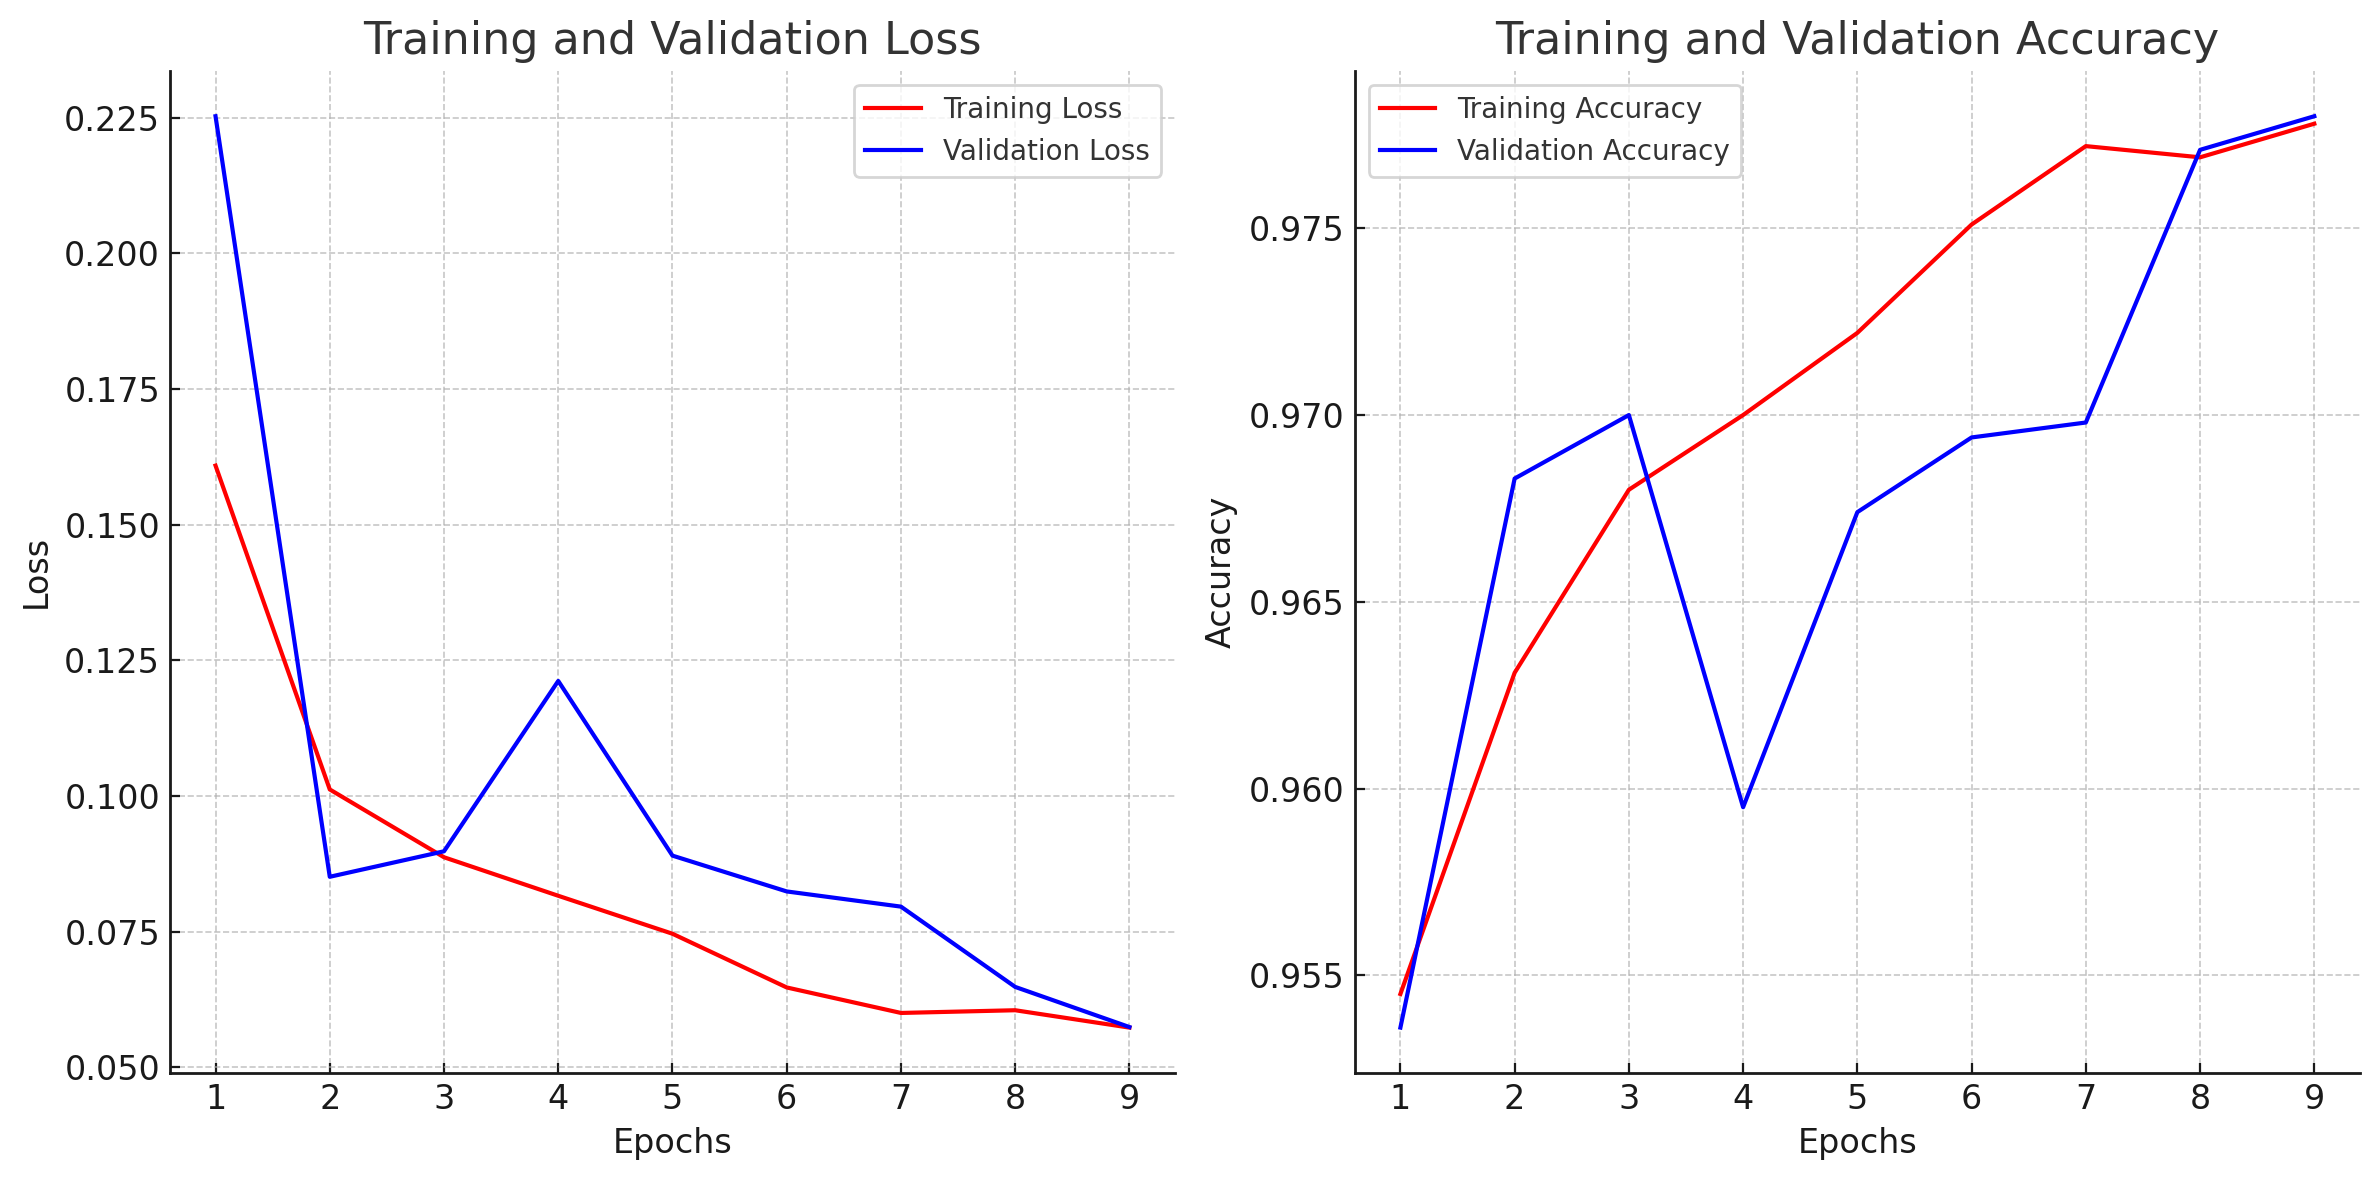![image.png]()

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model = load_model('/content/drive/MyDrive/Good model/building_localizer.h5')
evaluation = model.evaluate(X_val, y_val, batch_size=5)
print(evaluation)


8/8 [==============================] - 109s 13s/step - loss: 0.0349 - accuracy: 0.9882
[0.034905705600976944, 0.9881818890571594]


Using X_train

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model_path = '/content/drive/MyDrive/Good model/building_localizer.h5'  # Update with your model path
model = load_model(model_path)


# Predict masks on the validation set
pred_masks = model.predict(X_val)


2/2 [==============================] - 110s 22s/step


39


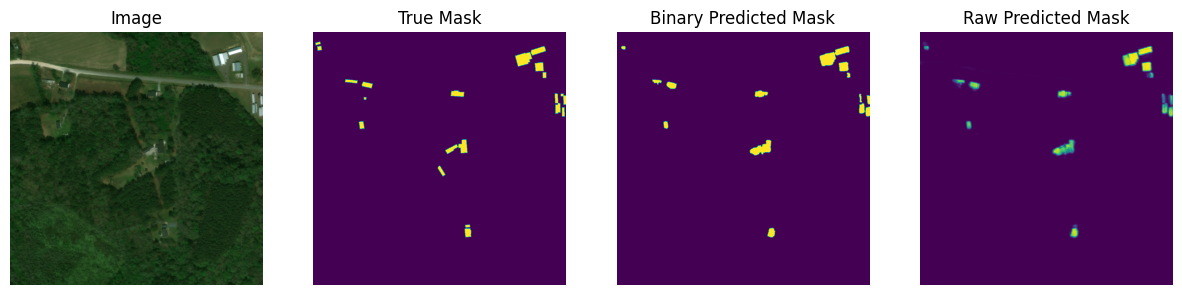

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


pred_masks_binary = (pred_masks > 0.32).astype(np.uint8)



# Function to display images
def display(display_list, title_list,index):
    plt.figure(figsize=(15, 5))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title_list[i])
        # Ensure the mask has 3 dimensions
        if display_list[i].ndim == 2:
            display_list[i] = np.expand_dims(display_list[i], axis=-1)
        img = tf.keras.preprocessing.image.array_to_img(display_list[i])
        #Saving the img
        if title_list[i] == 'Image':
            img.save(f'polygon_testing/{title_list[i]}_{index}.png')
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Choose a random index from the validation set
index = 39

print(index)
# Display the original image, the true mask, and the predicted mask
display([X_val[index], y_val[index], pred_masks_binary[index], pred_masks[index]], ["Image", "True Mask", "Binary Predicted Mask", "Raw Predicted Mask"],index)


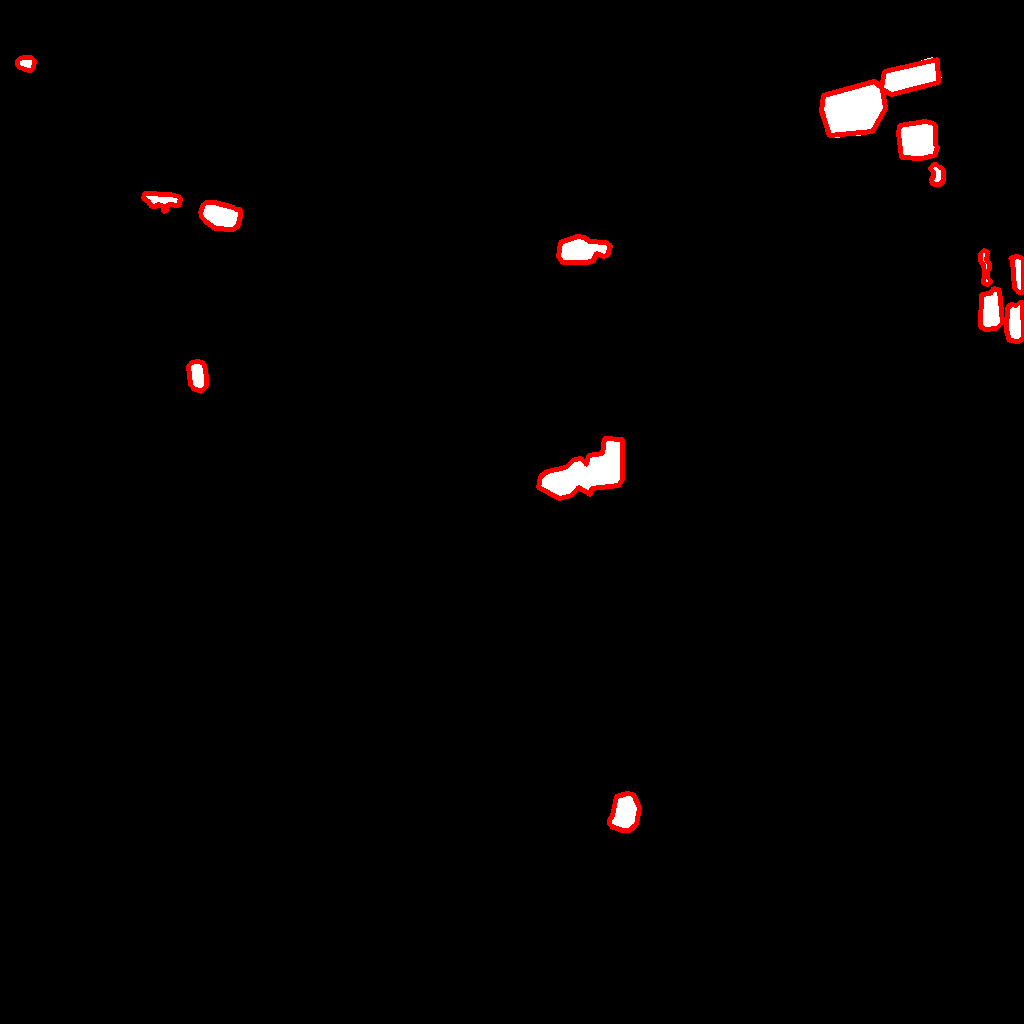

['POLYGON ((633 794, 627 793, 616 796, 612 815, 609 820, 609 824, 611 826, 622 830, 629 830, 636 824, 639 807, 633 794))', 'POLYGON ((622 439, 604 438, 602 453, 588 455, 586 464, 581 458, 574 459, 565 467, 547 471, 540 476, 538 487, 559 498, 571 495, 578 487, 590 494, 591 488, 618 485, 622 479, 622 439))', 'POLYGON ((191 362, 188 366, 190 384, 193 388, 201 391, 206 385, 206 376, 204 365, 202 362, 197 361, 191 362))', 'POLYGON ((1022 302, 1019 302, 1016 305, 1011 304, 1007 307, 1006 330, 1009 340, 1018 341, 1023 338, 1022 302))', 'POLYGON ((993 288, 990 293, 981 294, 980 324, 981 327, 985 329, 996 328, 1002 322, 999 290, 993 288))', 'POLYGON ((1010 258, 1012 260, 1014 287, 1018 292, 1022 292, 1023 291, 1023 259, 1021 257, 1016 256, 1010 258))', 'POLYGON ((983 250, 980 253, 980 260, 983 265, 984 271, 983 283, 988 284, 990 282, 990 280, 987 277, 987 271, 989 268, 989 264, 986 259, 987 253, 986 252, 987 251, 983 250))', 'POLYGON ((558 256, 562 262, 587 262, 593 260, 596 253, 603 256, 607 2

In [ ]:
#https://pyimagesearch.com/2021/10/06/opencv-contour-approximation

import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# Function to convert a contour to WKT polygon string
def contour_to_wkt(contour):
    # Flatten the contour array to ensure it's 2D
    contour = contour.reshape(-1, 2)

    # Check if the contour is closed
    if len(contour) > 0 and not np.array_equal(contour[0], contour[-1]):
        # Add the first point to the end of the contour
        contour = np.vstack([contour, contour[0]])

    # Create WKT polygon string
    points = [tuple(point) for point in contour]
    return "POLYGON ((" + ", ".join(["{} {}".format(x, y) for x, y in points]) + "))"



# Initialize an empty list to store WKT polygons
wkt_polygons = []

# Load the image
img = cv2.imread("/content/polygon_testing/Binary Predicted Mask_39.png")
# Convert to greyscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the contours
contours, _ = cv2.findContours(img_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# For each contour approximate the curve and
# detect the shapes.
for cnt in contours:
    epsilon = 0.01*cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    # Change the color here to red
    cv2.drawContours(img, [approx], 0, (0, 0, 255), 3)
    # Convert contour to WKT polygon and add to the list
    wkt_polygons.append(contour_to_wkt(approx))

cv2_imshow(img)
cv2.waitKey(0)

# Print or return the wkt_polygons list as needed
print(wkt_polygons)


1/1 [==============================] - 0s 147ms/step
Prediction: [[9.9691689e-01 1.2921014e-07 2.8695571e-03 2.1348047e-04]]
Class: no-damage


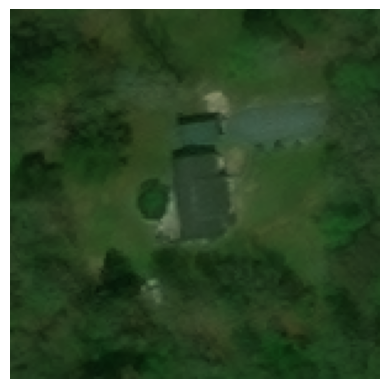

1/1 [==============================] - 0s 42ms/step
Prediction: [[9.9655020e-01 5.3209027e-07 3.1000760e-03 3.4928345e-04]]
Class: no-damage


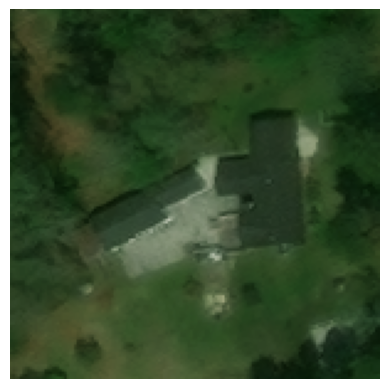

1/1 [==============================] - 0s 50ms/step
Prediction: [[9.5836323e-01 6.7168202e-08 1.6363444e-02 2.5273236e-02]]
Class: no-damage


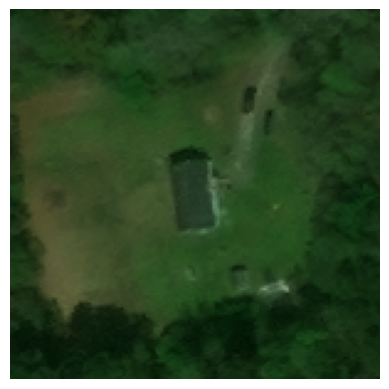

1/1 [==============================] - 0s 39ms/step
Prediction: [[9.6702498e-01 2.9021110e-02 3.9066644e-03 4.7300946e-05]]
Class: no-damage


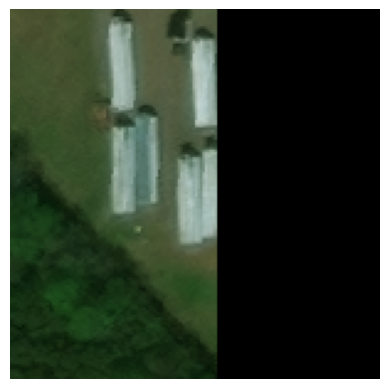

1/1 [==============================] - 0s 39ms/step
Prediction: [[9.9483204e-01 6.5890847e-05 3.4034057e-03 1.6985922e-03]]
Class: no-damage


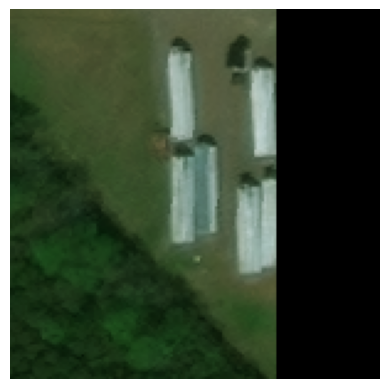

1/1 [==============================] - 0s 44ms/step
Prediction: [[9.1826099e-01 7.4405141e-02 7.2385864e-03 9.5192074e-05]]
Class: no-damage


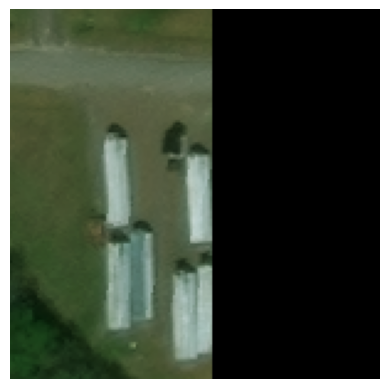

1/1 [==============================] - 0s 39ms/step
Prediction: [[9.7962898e-01 2.5366868e-05 8.4103933e-03 1.1935216e-02]]
Class: no-damage


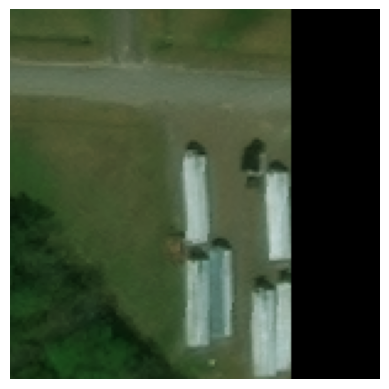

1/1 [==============================] - 0s 37ms/step
Prediction: [[9.9754983e-01 5.7857896e-08 2.0632832e-03 3.8688019e-04]]
Class: no-damage


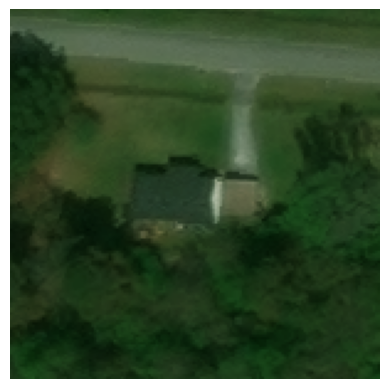

1/1 [==============================] - 0s 40ms/step
Prediction: [[9.897099e-01 3.973566e-07 8.472827e-03 1.816894e-03]]
Class: no-damage


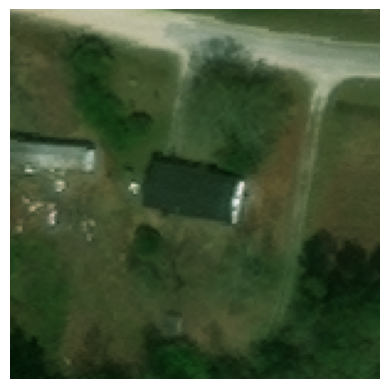

1/1 [==============================] - 0s 39ms/step
Prediction: [[9.9839920e-01 1.5799090e-07 1.2375851e-03 3.6314595e-04]]
Class: no-damage


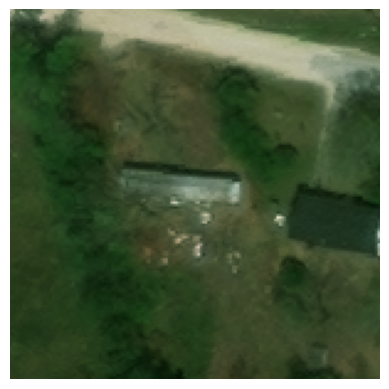

1/1 [==============================] - 0s 40ms/step
Prediction: [[9.9576354e-01 1.4787960e-07 1.0214156e-03 3.2148436e-03]]
Class: no-damage


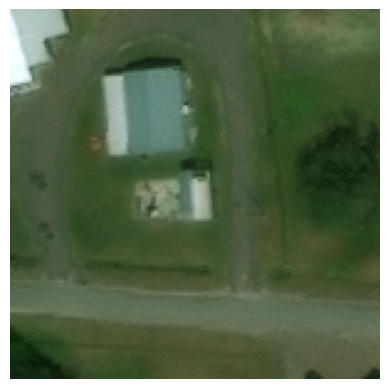

1/1 [==============================] - 0s 40ms/step
Prediction: [[9.9387109e-01 2.2239264e-07 1.6398582e-03 4.4888412e-03]]
Class: no-damage


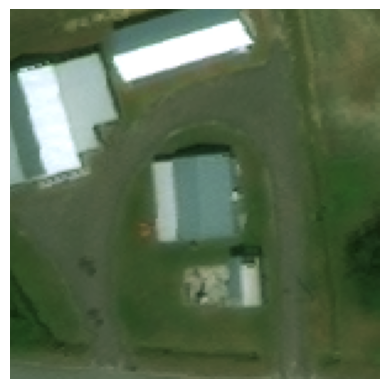

1/1 [==============================] - 0s 41ms/step
Prediction: [[9.9587244e-01 1.6383534e-07 6.9647358e-04 3.4309039e-03]]
Class: no-damage


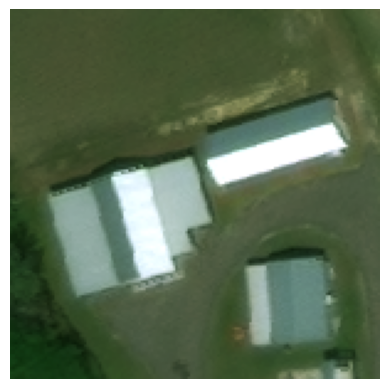

1/1 [==============================] - 0s 49ms/step
Prediction: [[3.0625066e-01 1.8552413e-07 6.8176007e-01 1.1989123e-02]]
Class: major damage


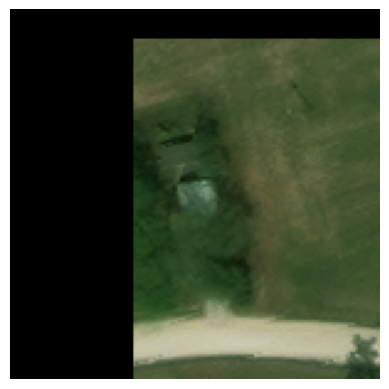

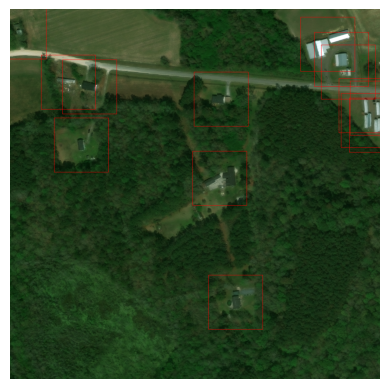

In [ ]:
import tifffile
from shapely.wkt import loads
import shapely.geometry
from shapely.ops import polygonize
from PIL import Image, ImageDraw
import os
import tensorflow as tf
from keras.models import load_model
import numpy as np

def get_bounding_box(wkt_polygon, margin=5):
    """
    Calculate the bounding box for a given polygon and expand it by the specified margin.
    :param wkt_polygon: WKT representation of the polygon.
    :param margin: Amount by which to expand the bounding box on each side.
    :return: Coordinates of the expanded bounding box.
    """

    try:
        polygon = loads(wkt_polygon)
    except Exception as e:
        return None

    polygon = loads(wkt_polygon)

    minx, miny, maxx, maxy = polygon.bounds
    center_x = (minx + maxx) / 2
    center_y = (miny + maxy) / 2
    minx = center_x - 75
    maxx = center_x + 75
    miny = center_y - 75
    maxy = center_y + 75
    # Get the Center of the the box. Return b
    # Expand the bounding box
    return [(minx, miny), (maxx, maxy)]

#Image path: /content/polygon_testing/Image_17.png
img = Image.open("/content/polygon_testing/Image_39.png")
img_for_crop = Image.open("/content/polygon_testing/Image_39.png")
classifier = load_model('/content/drive/MyDrive/Good model/building_classifier.h5')

def preprocess_image(image, target_size):
    """
    Preprocess the image for the classifier.
    :param image: PIL Image object.
    :param target_size: Tuple (width, height) expected by the classifier.
    :return: Preprocessed image.
    """
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = image.resize(target_size)
    image_array = np.asarray(image)
    image_array = image_array.astype('float32') / 255.0  # normalize
    return np.expand_dims(image_array, axis=0)

# Classifier's expected input size
input_size = (150, 150)
class_labels = ["no-damage", "minor damage", "major damage", "destroyed"]


for wkt_polygon in wkt_polygons:
    bbox = get_bounding_box(wkt_polygon)
    if bbox is not None:
        # Crop and preprocess the image
        cropped_image = img_for_crop.crop((bbox[0][0], bbox[0][1], bbox[1][0], bbox[1][1]))
        preprocessed_image = preprocess_image(cropped_image, input_size)

        # Classify the image
        prediction = classifier.predict(preprocessed_image)
        print("Prediction:", prediction)
        print("Class:", class_labels[np.argmax(prediction)])
        # Draw the boxes and show the cropped image
        draw = ImageDraw.Draw(img)
        draw.rectangle(bbox, outline="red")

        plt.imshow(cropped_image)
        plt.axis('off')
        plt.show()


# Show the original image with drawn boxes
plt.imshow(img)
plt.axis('off')
plt.show()
